## Create dataloader

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps
from utils.visualize_star import visualize
import yaml
from utils.circular_loss import CircularAELoss

In [45]:
with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# labels_path = config['labels_path']
# images_path = config['images_path']
labels_path = config['toy_labels_path']
images_path = config['toy_images_path']
n_rays = config['n_rays']

In [34]:
dataset = MyDataset(images_path, labels_path, n_rays)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

480


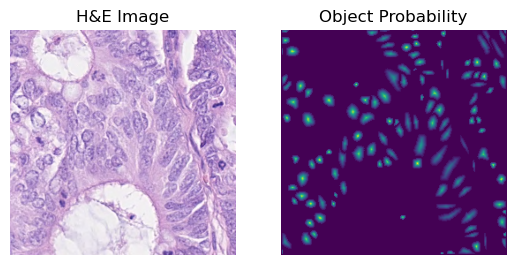

In [35]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


4


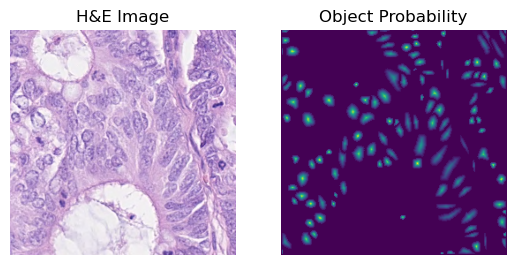

In [36]:
print(len(data))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()

In [37]:
image, obj_prob, star_distances, star_angles = data

## visualize "star points" from data loader

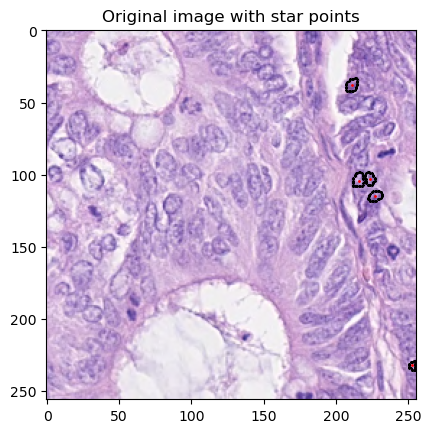

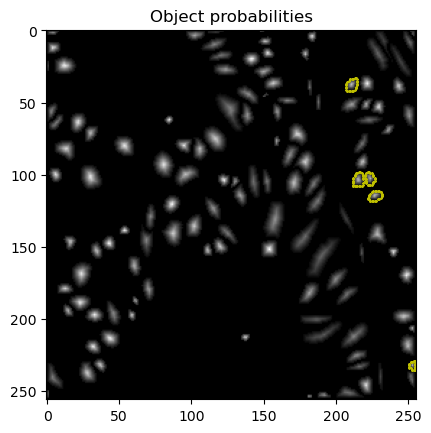

In [38]:
visualize(image[0], obj_prob[0], star_distances[0], star_angles[0])

In [39]:
print(star_distances[0].shape)
print(star_angles[0].shape)

torch.Size([256, 256, 32])
torch.Size([256, 256, 32])


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(3).to(device)
model1 = output_maps(n_rays=n_rays).to(device)

In [46]:
#Hyperparameters taken from paper:
batch_size = config['batch_size']
lr = config['lr']
num_epochs = config['num_epochs']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')
loss3 = CircularAELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training loop

In [47]:
from tqdm import tqdm

In [48]:
# save training loss
obj_prob_loss_epoch_train = []
dist_loss_epoch_train = []
angles_loss_epoch_train = []
total_loss_epoch_train = []
# save validation loss  
obj_prob_loss_epoch_val = []
dist_loss_epoch_val = []
angles_loss_epoch_val = []
total_loss_epoch_val = []
num_batches_train = len(train_loader)
num_batches_val = len(val_loader) 
# training loop 
for epoch in (range(num_epochs)):
    print("Epoch: {}".format(epoch))
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    angles_running_loss = 0.0
    total_running_loss = 0.0
    print("Train")
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        # pdb.set_trace()
        outputs = model(images)
        pred_prob, star = model1(outputs)
        pred_dist = star[:,:n_rays,:,:]
        pred_angles = star[:,n_rays:,:,:]
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss + angles_loss
        # pdb.set_trace()
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
        angles_running_loss += angles_loss.item()
        total_running_loss += loss.item()
    obj_prob_loss_epoch_train.append(obj_prob_running_loss/num_batches_train)
    dist_loss_epoch_train.append(dist_running_loss/num_batches_train)
    angles_loss_epoch_train.append(angles_running_loss/num_batches_train)
    total_loss_epoch_train.append(total_running_loss/num_batches_train)
    print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_train[-1], dist_loss_epoch_train[-1], angles_loss_epoch_train[-1],total_loss_epoch_train[-1]))


    model.eval()
    with torch.no_grad():
        obj_prob_running_loss = 0.0
        dist_running_loss = 0.0
        angles_running_loss = 0.0
        total_running_loss = 0.0
        print("Validation")
        for i, data in enumerate(val_loader):
            images, object_probabilities, star_poly_dist, star_angles = data
            images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
            outputs = model(images)
            pred_prob, star = model1(outputs)
            pred_dist = star[:,:n_rays,:,:]
            pred_angles = star[:,n_rays:,:,:]
            obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
            dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            loss = obj_prob_loss + dist_loss + angles_loss
            obj_prob_running_loss += obj_prob_loss.item()
            dist_running_loss += dist_loss.item()
            angles_running_loss += angles_loss.item()
            total_running_loss += loss.item()
        obj_prob_loss_epoch_val.append(obj_prob_running_loss/num_batches_val)
        dist_loss_epoch_val.append(dist_running_loss/num_batches_val)
        angles_loss_epoch_val.append(angles_running_loss/num_batches_val)
        total_loss_epoch_val.append(total_running_loss/num_batches_val)
        print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_val[-1], dist_loss_epoch_val[-1], angles_loss_epoch_val[-1],total_loss_epoch_val[-1]))

            


Epoch: 0
Train


24it [02:21,  5.88s/it]


Object Probability Loss: 0.08294465408350031, Distance Loss: 0.9142839759588242, Angle loss: 0.004681171810564895, Total loss: 1.0019098098079364
Validation
Object Probability Loss: 0.08218342810869217, Distance Loss: 1.0564532577991486, Angle loss: 0.004784314117083947, Total loss: 1.143420974413554
Epoch: 1
Train


24it [01:47,  4.49s/it]


Object Probability Loss: 0.0753124460267524, Distance Loss: 0.9033198406298956, Angle loss: 0.004078494860247399, Total loss: 0.9827107811967531
Validation
Object Probability Loss: 0.07974969719847043, Distance Loss: 1.0546068251132965, Angle loss: 0.0041639418341219425, Total loss: 1.1385204295317333
Epoch: 2
Train


24it [01:48,  4.50s/it]


Object Probability Loss: 0.07202129454041521, Distance Loss: 0.9030505046248436, Angle loss: 0.0038781878247391433, Total loss: 0.9789499876399835
Validation
Object Probability Loss: 0.07592817520101865, Distance Loss: 1.0547468960285187, Angle loss: 0.004165712821607788, Total loss: 1.134840766588847
Epoch: 3
Train


24it [02:22,  5.96s/it]


Object Probability Loss: 0.06980328432594736, Distance Loss: 0.9030848269661268, Angle loss: 0.0038466221497704587, Total loss: 0.9767347301046053
Validation
Object Probability Loss: 0.0736364300052325, Distance Loss: 1.054765671491623, Angle loss: 0.004136441935164233, Total loss: 1.1325385173161824
Epoch: 4
Train


24it [01:54,  4.76s/it]


Object Probability Loss: 0.06841981053973238, Distance Loss: 0.9030723931888739, Angle loss: 0.0038205764334027967, Total loss: 0.9753127843141556
Validation
Object Probability Loss: 0.07258978361884753, Distance Loss: 1.05472997824351, Angle loss: 0.004107722081243992, Total loss: 1.131427526473999


In [49]:
# save model dict
torch.save(model.state_dict(), './output/weights/model.pth')

## Inference